## 多変量ガウス分布モデル

多変量ガウス分布は、$k$ 次元の連続値ベクトル $x \in \mathbb{R}^k$ に対して、次の確率密度関数を持つ
$$
p(x; \mu, \Sigma) = \frac{1}{(2\pi)^{k/2} |\Sigma|^{1/2}} \exp \left( -\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) \right)
$$

- $\mu \in \mathbb{R}^k$：平均ベクトル（各特徴量の中心）
- $\Sigma \in \mathbb{R}^{k \times k}$：共分散行列（特徴量間の分散や相関）

---

## 正常データからのパラメータ推定

正常データ $\{ x^{(i)} \}_{i=1}^m$ を用いて、平均ベクトル $\mu$ と分散共分散行列 $\Sigma$ を推定する

$$
\mu = \frac{1}{m} \sum_{i=1}^{m} x^{(i)}
$$

$$
\Sigma = \frac{1}{m} \sum_{i=1}^{m} (x^{(i)} - \mu)(x^{(i)} - \mu)^T
$$

---

## 新しいデータの異常スコア算出

未知のデータ $x$ に対して、正規分布からの異常度を以下の確率で評価する

$$
p(x) = p(x; \mu, \Sigma)
$$

この確率値が小さいほど、「通常とは異なる異常なデータ」である

---

## 閾値 $\epsilon$ による異常判定

確率密度 $p(x)$ がある閾値 $\epsilon$ 未満であれば異常、それ以外は正常

$$
\hat{y} = 
\begin{cases}
1 & \text{if } p(x) < \epsilon \quad \text{(異常)} \\
0 & \text{if } p(x) \ge \epsilon \quad \text{(正常)}
\end{cases}
$$

---

## 閾値の最適化と性能評価（F1スコア）

検証データにおいて、様々な $\epsilon$ に対して予測を行い、F1スコアが最大になる $\epsilon$ を選ぶ

適合率（Precision）：

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

再現率（Recall）：

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

F1スコア：

$$
F_1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$


- $TP$：異常を正しく検出した件数（True Positive）  
- $FP$：正常を誤って異常と予測した件数（False Positive）  
- $FN$：異常を見逃した件数（False Negative）



In [ ]:
#ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Train shape: (306, 2), Validation shape: (306, 2), Label shape: (306,)
Best epsilon: 8.971080231004169e-05
Best F1 score: 0.8750000000000001


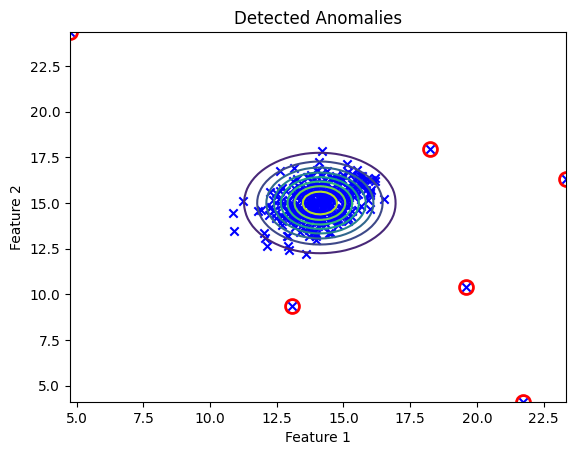

In [ ]:
# データ読み込み
train_df = pd.read_csv("data/tr_server_data.csv")     # 学習用 (正常のみの特徴量)
val_df = pd.read_csv("data/cv_server_data.csv")       # 検証用 (特徴量のみ)
gt_df = pd.read_csv("data/gt_server_data.csv")        # 検証用ラベル (正常=0, 異常=1)

X_train = train_df.values
X_val = val_df.values
y_val = gt_df.values.flatten()       # 1次元に変換

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Label shape: {y_val.shape}")

#  平均・分散推定
def estimate_gaussian(X):
    mu = np.mean(X, axis=0)
    var = np.var(X, axis=0)
    return mu, var

mu, var = estimate_gaussian(X_train)

# 多変量ガウス確率の計算
def multivariate_gaussian(X, mu, var):
    k = len(mu)
    if var.ndim == 1:
        var = np.diag(var)
    X = X - mu
    inv_var = np.linalg.inv(var)
    exp_term = np.sum((X @ inv_var) * X, axis=1)
    coeff = 1 / ( (2 * np.pi)**(k/2) * np.linalg.det(var)**0.5 )
    return coeff * np.exp(-0.5 * exp_term)

p_val = multivariate_gaussian(X_val, mu, var)

# 閾値探索関数
def select_threshold(y_val, p_val):
    best_epsilon = 0
    best_F1 = 0
    step = (max(p_val) - min(p_val)) / 1000

    for eps in np.arange(min(p_val), max(p_val), step):
        pred = p_val < eps
        tp = np.sum((pred == 1) & (y_val == 1))
        fp = np.sum((pred == 1) & (y_val == 0))
        fn = np.sum((pred == 0) & (y_val == 1))
        if tp + fp == 0 or tp + fn == 0:
            continue
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        F1 = 2 * prec * rec / (prec + rec)
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = eps

    return best_epsilon, best_F1

epsilon, F1 = select_threshold(y_val, p_val)

print(f"Best epsilon: {epsilon}")
print(f"Best F1 score: {F1}")

# 訓練データの確率計算と異常検出
p_train = multivariate_gaussian(X_train, mu, var)
outliers = p_train < epsilon

# 可視化 (特徴量が2次元の場合のみ)
def visualize_fit(X, mu, var):
    plt.scatter(X[:, 0], X[:, 1], marker='x', c='b')
    x = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
    y = np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), 100)
    X1, X2 = np.meshgrid(x, y)
    Z = multivariate_gaussian(np.c_[X1.ravel(), X2.ravel()], mu, var)
    Z = Z.reshape(X1.shape)
    plt.contour(X1, X2, Z, levels=10)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Gaussian Fit Contour")
    visualize_fit(X_train, mu, var)
    plt.plot(X_train[outliers, 0], X_train[outliers, 1], 'ro',
             markersize=10, markerfacecolor='none', markeredgewidth=2)
    plt.title("Detected Anomalies")
    plt.show()
